<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter04/Detectron2-Chapter04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 04 - Architecture of Faster R-CNN in Detectron2

In [ ]:
import torch
print(torch.__version__)

1.12.1


In [ ]:
!python -m pip install \
'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-fuk03nky
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-fuk03nky
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 151 kB 77.8 MB/s 
     |████████████████████████████████| 1.5 MB 70.0 MB/s 
     |████████████████████████████████| 549 kB 65.8 MB/s 
     |████████████████████████████████| 255 kB 80.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |█████████████████████████

In [ ]:
import detectron2
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
# Suppress some user warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
# Select a model
config_file = "COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file)
cfg.merge_from_file(config_file)
# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
score_thresh_test = 0.95
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh_test
predictor = DefaultPredictor(cfg)

model_final_721ade.pkl: 136MB [00:04, 27.4MB/s]                           


# The input

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/800x800image/input.jpeg

--2023-01-12 15:32:34--  https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/800x800image/input.jpeg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/main/datasets/800x800image/input.jpeg [following]
--2023-01-12 15:32:34--  https://raw.githubusercontent.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/main/datasets/800x800image/input.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96817 (95K) [image/jpeg]
Saving to: ‘input.jpeg’

input.jpeg          100%[===========

In [ ]:
import cv2
input_url = "input.jpeg"
img = cv2.imread(input_url)
height, width = img.shape[:2]
image = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))

# Backbone

In [ ]:
backbone = predictor.model.backbone
type(backbone)

detectron2.modeling.backbone.resnet.ResNet

In [ ]:
print(backbone)

ResNet(
  (stem): BasicStem(
    (conv1): Conv2d(
      3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
      (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
    )
  )
  (res2): Sequential(
    (0): BottleneckBlock(
      (shortcut): Conv2d(
        64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
        (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
      )
      (conv1): Conv2d(
        64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
      (conv2): Conv2d(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
      (conv3): Conv2d(
        64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
        (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
      )
    )
    (1): BottleneckBlock(
      (conv1): Conv2d(
        256, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [ ]:
with torch.no_grad():
  # Input to ResNet is of the form (NxCxHxW)
  rnInput = image.to("cuda").unsqueeze(0)
  stem = backbone.stem(rnInput)
  res2 = backbone.res2(stem)
  res3 = backbone.res3(res2)
  res4 = backbone.res4(res3)
  print(rnInput.shape)
  print(stem.shape)
  print(res2.shape)
  print(res3.shape)
  print(res4.shape)

torch.Size([1, 3, 800, 800])
torch.Size([1, 64, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 512, 100, 100])
torch.Size([1, 1024, 50, 50])


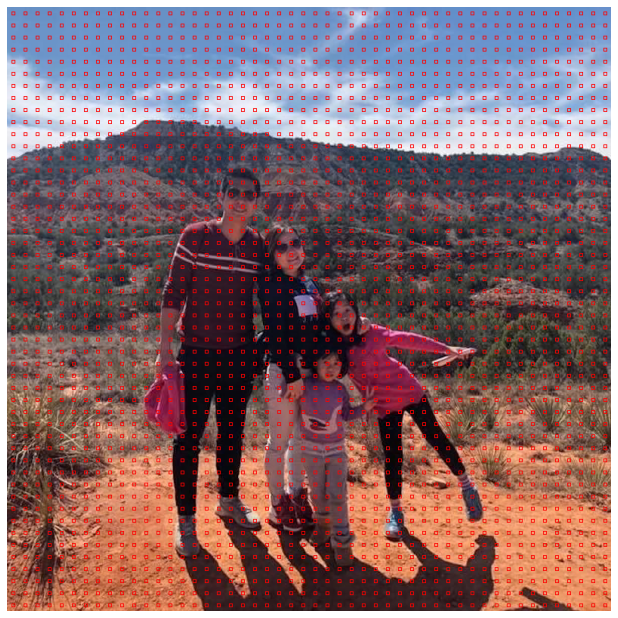

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image):
  dpi = plt.rcParams["figure.dpi"]
  height, width = image.shape[:2]
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(image)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

feature_h, feature_w = res4.shape[2:]
sub_sample = height/feature_h
new_img = img.copy()
# the feature map points and corresponding regions
rect_w = 4
rect_h = 4
for i in range(feature_h):
  for j in range(feature_w):
    center_x = sub_sample * j + sub_sample/2
    center_y = sub_sample * i + sub_sample/2
    start_x = int(center_x - rect_w/2)
    start_y = int(center_y - rect_h/2)
    end_x = int(center_x + rect_w/2)
    end_y = int(center_y + rect_h/2)
    cv2.rectangle(new_img, (start_x, start_y), (end_x, end_y), (0, 0, 255))
imshow(new_img[:,:,::-1])

# Region Proposal Network
RPN

In [ ]:
rpn = predictor.model.proposal_generator
type(rpn)

detectron2.modeling.proposal_generator.rpn.RPN

In [ ]:
print(rpn)

RPN(
  (rpn_head): StandardRPNHead(
    (conv): Conv2d(
      1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation): ReLU()
    )
    (objectness_logits): Conv2d(1024, 15, kernel_size=(1, 1), stride=(1, 1))
    (anchor_deltas): Conv2d(1024, 60, kernel_size=(1, 1), stride=(1, 1))
  )
  (anchor_generator): DefaultAnchorGenerator(
    (cell_anchors): BufferList()
  )
)


### Anchor Generator

In [ ]:
print(cfg.MODEL.ANCHOR_GENERATOR.SIZES)
print(cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS)

[[32, 64, 128, 256, 512]]
[[0.5, 1.0, 2.0]]


45 23
32 32
23 45
91 45
64 64
45 91
181 91
128 128
91 181
363 181
256 256
181 363
725 363
512 512
363 725


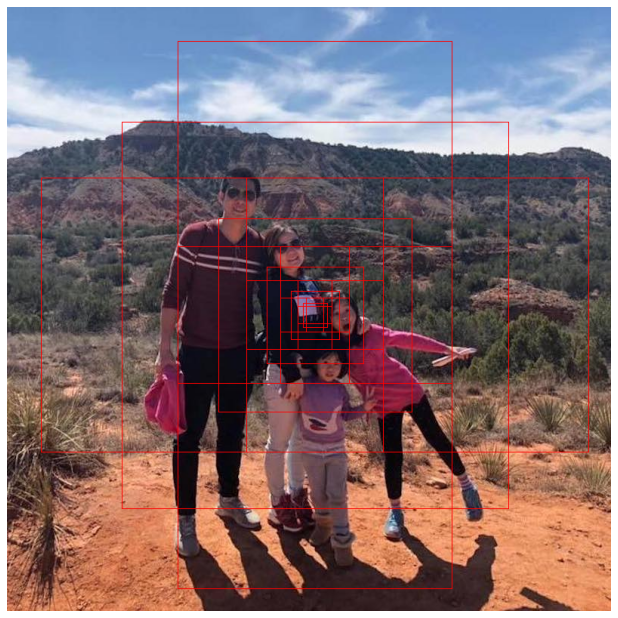

In [ ]:
sizes = cfg.MODEL.ANCHOR_GENERATOR.SIZES
ratios = cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS
new_img = img.copy()
# the feature
for size in sizes[0]:
  for ratio in ratios[0]:
    anchor_h = size*np.sqrt(ratio)
    anchor_w = size/np.sqrt(ratio)
    center_x = sub_sample * feature_h/2 + sub_sample/2
    center_y = sub_sample * feature_w/2 + sub_sample/2
    x0 = int(center_x - anchor_w/2)
    y0 = int(center_y - anchor_h/2)
    x1 = int(center_x + anchor_w/2)
    y1 = int(center_y + anchor_h/2)
    print(x1 - x0, y1 - y0)
    cv2.rectangle(new_img, (x0, y0), (x1, y1), (0, 0, 255))
imshow(new_img[:,:,::-1])

In [ ]:
# generate anchors
anchors = rpn.anchor_generator([res4])
print(anchors[0].tensor.shape)

torch.Size([37500, 4])


45 23
32 32
23 45
91 45
64 64
45 91
181 91
128 128
91 181
363 181
256 256
181 363
725 363
512 512
363 725


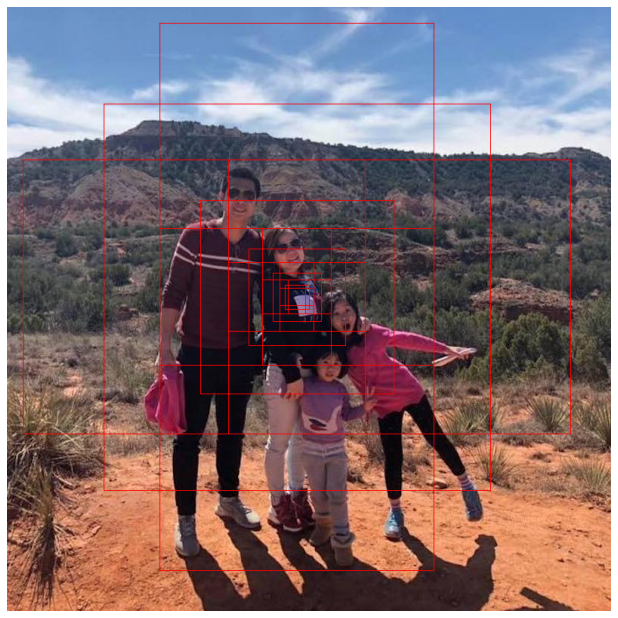

In [ ]:
# Anchors of the middle point
new_img = img.copy()
# the feature
col_idx = 24
row_idx = 24
startBox = (row_idx*50 + col_idx)*15
for i in range(startBox, startBox + 15):
  anchors_np = anchors[0].tensor[i].to("cpu").numpy()
  x0, y0, x1, y1 = [int(v) for v in anchors_np]
  print(x1 - x0, y1 - y0)
  cv2.rectangle(new_img, (x0, y0), (x1, y1), (0, 0, 255))
imshow(new_img[:,:,::-1])

### RPN Head

In [ ]:
rpn.rpn_head

StandardRPNHead(
  (conv): Conv2d(
    1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (activation): ReLU()
  )
  (objectness_logits): Conv2d(1024, 15, kernel_size=(1, 1), stride=(1, 1))
  (anchor_deltas): Conv2d(1024, 60, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
pred_objectness_logits, pred_anchor_deltas = rpn.rpn_head([res4])
print(pred_objectness_logits[0].shape)
print(pred_anchor_deltas[0].shape)

torch.Size([1, 15, 50, 50])
torch.Size([1, 60, 50, 50])


### Loss calculation

In [ ]:
print(cfg.MODEL.RPN.IOU_THRESHOLDS)

[0.3, 0.7]


In [ ]:
print(cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE)
print(cfg.MODEL.RPN.POSITIVE_FRACTION)

256
0.5


In [ ]:
# Ground-truths
from detectron2.modeling.roi_heads.roi_heads import Boxes
boxes = Boxes(torch.tensor([[190, 206, 352, 744],
         [419, 375, 633, 711],
         [375, 444, 479, 747],
         [330, 285, 423, 690]], device='cuda:0'))
classes = torch.tensor([0, 0, 0, 0], device='cuda:0')
gt_instance = detectron2.structures.instances.Instances(image_size=(800, 800))
gt_instance.set('gt_boxes', boxes)
gt_instance.set('gt_classes', classes)
gt_instances = [gt_instance] # list of gt instances for each image

Sample mini-batch and calculation of classification loss (objectness loss) and regression loss (box location loss).

In [ ]:
gt_labels, gt_boxes = rpn.label_and_sample_anchors(anchors, gt_instances)
print(gt_labels[0].shape)
print(gt_boxes[0].shape)

torch.Size([37500])
torch.Size([37500, 4])


In [ ]:
np_gt_boxes = gt_boxes[0].to("cpu").numpy()
print(np.unique(np_gt_boxes, axis=0))

[[190. 206. 352. 744.]
 [330. 285. 423. 690.]
 [375. 444. 479. 747.]
 [419. 375. 633. 711.]]


In [ ]:
na = gt_labels[0].to("cpu").numpy()
print('positive', sum([x == 1 for x in na]))
print('negative', sum([x == 0 for x in na]))
print('ignore', sum([x == -1 for x in na]))

positive 42
negative 214
ignore 37244


# Proposal Predictions
NMS parameters

In [ ]:
print('pre_nms_topk train', cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN)
print('pre_nms_topk test', cfg.MODEL.RPN.PRE_NMS_TOPK_TEST)
print('post_nms_topk train', cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN)
print('post_nms_topk test', cfg.MODEL.RPN.POST_NMS_TOPK_TEST)
print('nms_thresh', cfg.MODEL.RPN.NMS_THRESH)

pre_nms_topk train 12000
pre_nms_topk test 6000
post_nms_topk train 2000
post_nms_topk test 1000
nms_thresh 0.7


The proposals

In [ ]:
pred_objectness_logits = [
            # (N, A, Hi, Wi) -> (N, Hi, Wi, A) -> (N, Hi*Wi*A)
            score.permute(0, 2, 3, 1).flatten(1)
            for score in pred_objectness_logits
        ]
pred_anchor_deltas = [
    # (N, A*B, Hi, Wi) -> (N, A, B, Hi, Wi) -> (N, Hi, Wi, A, B) -> (N, Hi*Wi*A, B)
    x.view(x.shape[0], -1, 4, x.shape[-2], x.shape[-1])
    .permute(0, 3, 4, 1, 2)
    .flatten(1, -2)
    for x in pred_anchor_deltas
]
proposals = rpn.predict_proposals(anchors, pred_objectness_logits, pred_anchor_deltas, [(800, 800)])
print(proposals[0].proposal_boxes.tensor.shape)
print(proposals[0].objectness_logits.shape)


torch.Size([1000, 4])
torch.Size([1000])


# The Region of Interest Heads (ROI heads)

Sampling and labeling parameters

In [ ]:
print('iou thresh', cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS)
print('batch size', cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE)
print('pos fraction', cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION)


iou thresh [0.5]
batch size 512
pos fraction 0.25


In [ ]:
roi_heads = predictor.model.roi_heads
print(roi_heads)

Res5ROIHeads(
  (pooler): ROIPooler(
    (level_poolers): ModuleList(
      (0): ROIAlign(output_size=(14, 14), spatial_scale=0.0625, sampling_ratio=0, aligned=True)
    )
  )
  (res5): Sequential(
    (0): BottleneckBlock(
      (shortcut): Conv2d(
        1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False
        (norm): FrozenBatchNorm2d(num_features=2048, eps=1e-05)
      )
      (conv1): Conv2d(
        1024, 512, kernel_size=(1, 1), stride=(2, 2), bias=False
        (norm): FrozenBatchNorm2d(num_features=512, eps=1e-05)
      )
      (conv2): Conv2d(
        512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (norm): FrozenBatchNorm2d(num_features=512, eps=1e-05)
      )
      (conv3): Conv2d(
        512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False
        (norm): FrozenBatchNorm2d(num_features=2048, eps=1e-05)
      )
    )
    (1): BottleneckBlock(
      (conv1): Conv2d(
        2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False

### pooler

In [ ]:
print(roi_heads.pooler)

ROIPooler(
  (level_poolers): ModuleList(
    (0): ROIAlign(output_size=(14, 14), spatial_scale=0.0625, sampling_ratio=0, aligned=True)
  )
)


In [ ]:
x = roi_heads.pooler([res4], [proposals[0].proposal_boxes])
print(x.shape)

torch.Size([1000, 1024, 14, 14])


### res5

In [ ]:
box_features = roi_heads.res5(x)
print(box_features.shape)

torch.Size([1000, 2048, 7, 7])


### box predictors

In [ ]:
print(roi_heads.box_predictor)

FastRCNNOutputLayers(
  (cls_score): Linear(in_features=2048, out_features=81, bias=True)
  (bbox_pred): Linear(in_features=2048, out_features=320, bias=True)
)


In [ ]:
predictions = roi_heads.box_predictor(box_features.mean(dim=(2, 3)))
cls_score, bbox_pred = predictions
print(cls_score.shape)
print(bbox_pred.shape)

torch.Size([1000, 81])
torch.Size([1000, 320])


In [ ]:
pred_instances, _ = roi_heads.box_predictor.inference(predictions, proposals)
output = roi_heads.forward_with_given_boxes({'res4': res4}, pred_instances)
print(output)

[Instances(num_instances=3, image_height=800, image_width=800, fields=[pred_boxes: Boxes(tensor([[196.7818, 209.4423, 369.8124, 719.2922],
        [408.7937, 364.5682, 636.0513, 714.8391],
        [362.1954, 443.2558, 473.5189, 731.7020]], device='cuda:0',
       grad_fn=<IndexBackward0>)), scores: tensor([0.9995, 0.9993, 0.9879], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([0, 0, 0], device='cuda:0')])]


In [ ]:
print(cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
print(cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST)


0.95
0.5


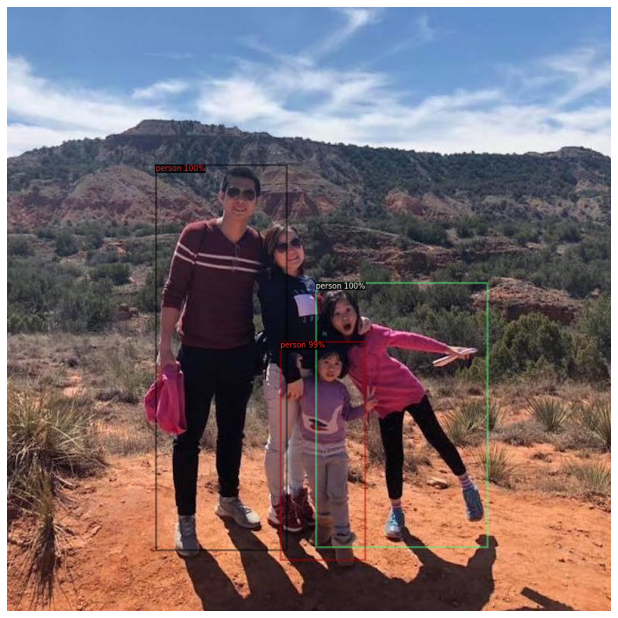

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
v = Visualizer(img[:, :, ::-1], metadata)
instances = output[0].to("cpu")
annotated_img = v.draw_instance_predictions(instances)
imshow(annotated_img.get_image())